In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from astropy.table import Table, vstack
import glob

import matplotlib.style as style
style.use('seaborn-colorblind')

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize']

[12.0, 10.0]

## Format definition

In [2]:
popt_mc_array = np.array([2229.79703976, 2037.02309679, 2416.18446325])
popt_data = np.array([2225.02302857])

In [4]:
OPT_EFF=[100, 90, 110]
colors = ['C0', 'C1', 'C2']
labels = ['MC', 'MC (-10% optical efficiency)', 'MC (+10% optical efficiency)']
labels_file = ['MC', 'MC_minus_10', 'MC_plus_10']
linestyles = ['solid', 'dashed', 'dashed']
facecolors = ['C0', 'none', 'none']

## Let's plot it out

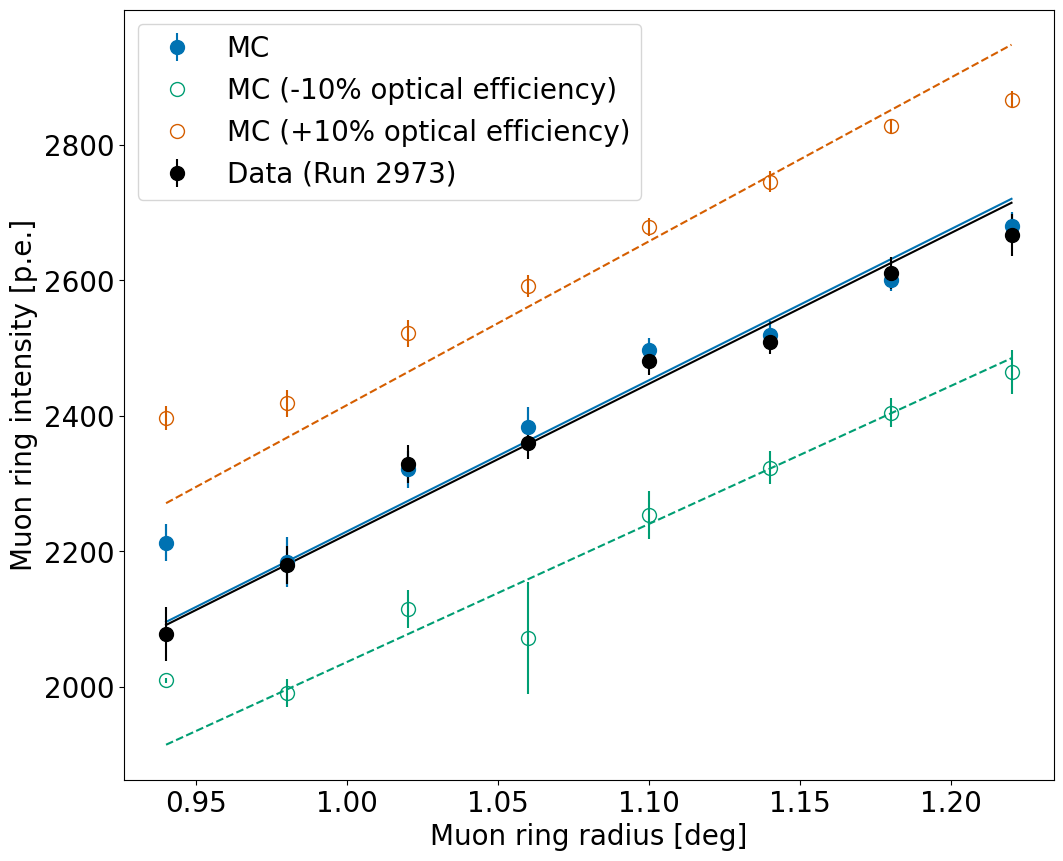

In [5]:
fig, ax = plt.subplots()

for i, (opt_eff, col, label, linestyle, facecolor) in enumerate(zip(OPT_EFF, colors, labels, linestyles, facecolors)):
        
    x_centers = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,0]
    intensity_mc = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,1]
    intensity_mc_error = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,2]

    ax.errorbar(x_centers, intensity_mc, yerr=np.array(intensity_mc_error), ls='',
                 ms=10, fmt='o', markeredgecolor=col, color=facecolor, label = label)
    ax.errorbar(x_centers, intensity_mc, yerr=np.array(intensity_mc_error), ls='',
                 ms=10, fmt='', markeredgecolor=col, color=col)
    ax.plot(x_centers, popt_mc_array[i] * x_centers, color=col, ls=linestyle)
    
    
    x_centers = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,0]
    intensity_mc = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,1]
    intensity_mc_error = np.loadtxt(f'data/ring_radius_{labels_file[i]}.txt')[:,2]

x_centers = np.loadtxt(f'data/ring_radius_data.txt')[:,0]
intensity_data = np.loadtxt(f'data/ring_radius_data.txt')[:,1]
intensity_data_error = np.loadtxt(f'data/ring_radius_data.txt')[:,2]

ax.errorbar(x_centers, intensity_data, yerr=intensity_data_error, color = 'k',  
            label = 'Data (Run 2973)', ls='', fmt='o', ms=10)
ax.plot(x_centers, popt_data * x_centers, color='k')


ax.legend(ncol=1)
ax.set_xlabel('Muon ring radius [deg]')
ax.set_ylabel('Muon ring intensity [p.e.]')

!mkdir -p figures

fig.savefig('figures/intensity_vs_radius_scipy_errors.png')
fig.savefig('figures/intensity_vs_radius_scipy_errors.pdf')